**GROUP MEMEBRS**

Harshitha Saripilli(hs759)

Harshith Kanagala(hk536)

Abhinesh Goud Panjugula(ap2787)

Chaitanya Karnati(ck338)


In [7]:
# Importing the required libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')

Add a new feature named 'TotalSF' to both the train and test data by combining the square footage of the basement, first floor, and second floor.

In [8]:
# Feature Engineering
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

Lets analyze the effect of this new feature'TotalSF'addition using graphs

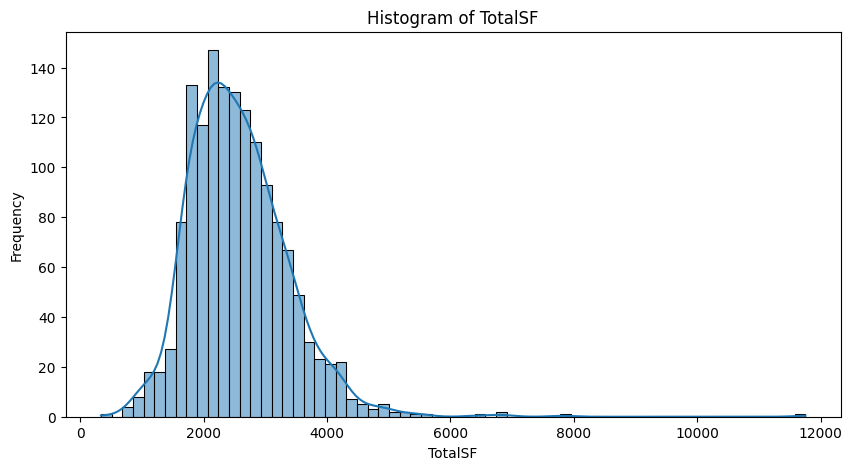

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df["TotalSF"], kde=True)
plt.title("Histogram of TotalSF")
plt.xlabel("TotalSF")
plt.ylabel("Frequency")
plt.show()

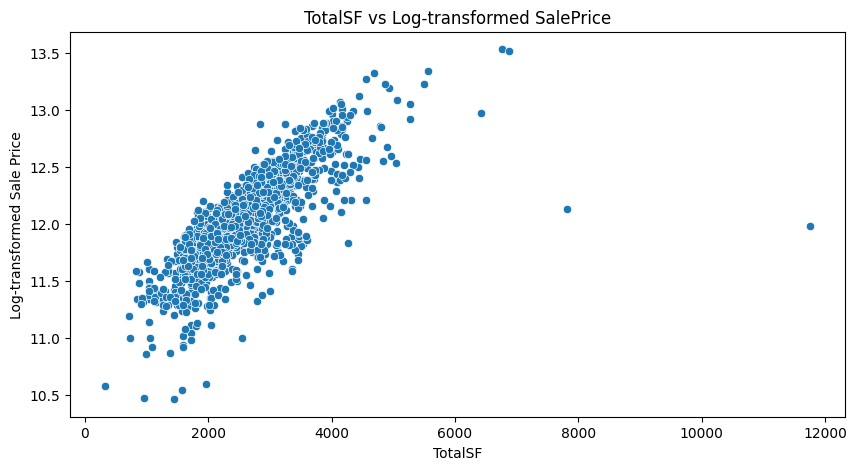

In [10]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="TotalSF", y="SalePrice", data=train_df.assign(SalePrice=np.log(train_df["SalePrice"])))
plt.title("TotalSF vs Log-transformed SalePrice")
plt.xlabel("TotalSF")
plt.ylabel("Log-transformed Sale Price")
plt.show()

New feature has a linear relationship with the target variable, but Outliers can negatively impact the model's performance. So removing outliers to improve the overall fit of the model.

In [11]:
# Remove outliers
train_df = train_df[train_df['TotalSF'] < 6000]

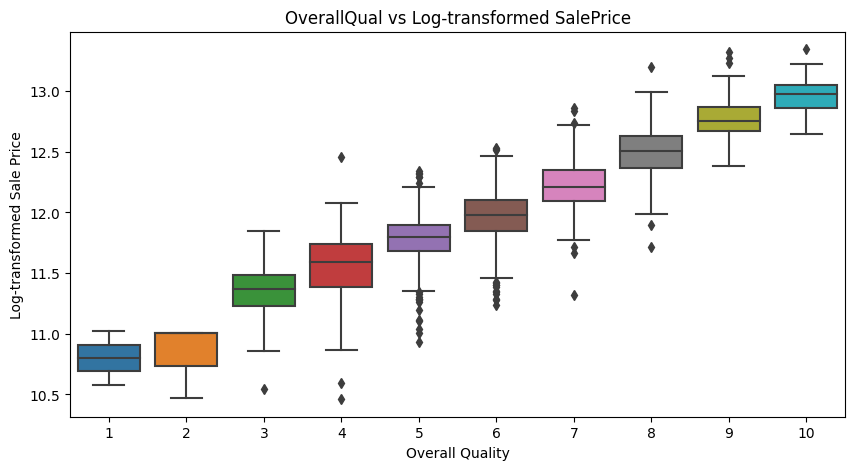

In [12]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_df.assign(SalePrice=np.log(train_df["SalePrice"])))
plt.title("OverallQual vs Log-transformed SalePrice")
plt.xlabel("Overall Quality")
plt.ylabel("Log-transformed Sale Price")
plt.show()

<ipython-input-13-2cbd511273fe>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_df.corr()


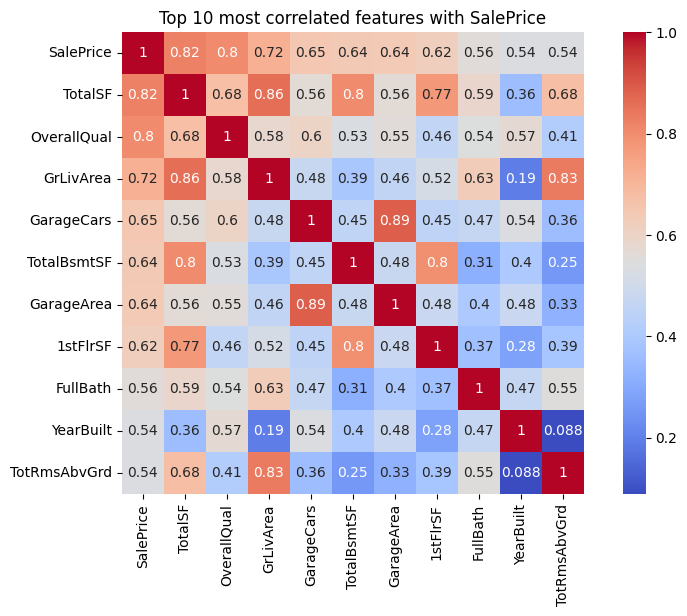

In [13]:
# Compute the correlation matrix and sort by the highest correlation with SalePrice
corr_matrix = train_df.corr()
top_corr_features = corr_matrix.nlargest(11, "SalePrice")["SalePrice"].index

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap="coolwarm", square=True)
plt.title("Top 10 most correlated features with SalePrice")
plt.show()

Above plot shows the top 10 features that have the highest correlation with SalePrice. I tried using only these features as they are most important predictors for the target variable, but the outcome was not so fruitful. So used all of the features instead.

Defined a function named preprocess_data that preprocesses the data by dropping the 'Id' column (if present) and identifying numerical and categorical features. It then applies the function to the train and test data and stores the results in new variables.

In [14]:
# Preprocess the data
def preprocess_data(df, is_train=True):
    if "Id" in df.columns:
        df = df.drop(["Id"], axis=1)
    num_features = df.select_dtypes(include=[np.number]).columns
    cat_features = df.select_dtypes(include=[object]).columns

    if is_train:
        num_features = num_features.drop("SalePrice")

    return df, num_features, cat_features


train_df, train_num_features, train_cat_features = preprocess_data(train_df)
test_df, test_num_features, test_cat_features = preprocess_data(test_df, is_train=False)

Define the input features X and the target variable y. The target variable is log-transformed to improve model performance.

In [15]:
X = train_df.drop("SalePrice", axis=1)
y = np.log(train_df["SalePrice"])

Define the preprocessing pipeline using `ColumnTransformer` from `sklearn.compose`. It applies a mean imputer and standard scaler to numerical features, and a most frequent imputer and one-hot encoder to categorical features. The `preprocessor` variable stores the pipeline.

In [16]:
# Preprocessing pipeline
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_train", num_transformer, train_num_features),
        ("cat_train", cat_transformer, train_cat_features),
        ("num_test", num_transformer, test_num_features),
        ("cat_test", cat_transformer, test_cat_features),
    ],
    remainder="drop",
)

Create an XGBoost model using XGBRegressor from xgboost. Combine the preprocessor and model_xgb variables using Pipeline from sklearn.pipeline.

In [17]:
# Create an XGBoost model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
pipeline_xgb = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_xgb)])

Define the parameter grid for hyperparameter tuning. It includes different values for learning rate, number of estimators, maximum depth, and subsampling rate.

In [18]:
# Define the parameter grid
param_grid = {
    "model__learning_rate": [0.01, 0.1],
    "model__n_estimators": [100, 500, 1000],
    "model__max_depth": [3, 6],
    "model__subsample": [0.5, 1],
}

Perform the grid search using GridSearchCV from sklearn.model_selection. It applies 5-fold cross-validation, uses the negative root mean squared error (RMSE) as the scoring metric, and runs the grid search in parallel using all available CPU cores. The best model is stored in the grid_search variable.

In [19]:
# Perform Grid Search
grid_search = GridSearchCV(pipeline_xgb, param_grid, scoring="neg_root_mean_squared_error", cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X, y)
# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", -grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 1000, 'model__subsample': 0.5}
Best RMSE score found:  0.11643766402544493


Make predictions on the test data using the best estimator found by the grid search. It then reverses the log transformation applied to the target variable earlier to obtain the actual sale prices. Creates a submission dataframe with the predicted sale prices and saves it as a CSV file named submission2.csv. The Id column is taken from the original test data.

In [20]:
# Predict the test data
test_predictions = grid_search.best_estimator_.predict(test_df)
test_saleprice = np.exp(test_predictions)  # Reverse the log transformation applied earlier

# Create a submission DataFrame
submission_df = pd.DataFrame({'Id': pd.read_csv('/content/sample_data/test.csv')['Id'], 'SalePrice': test_saleprice})

#print dataframe
print(submission_df.head())
# Save the submission DataFrame as a CSV file
submission_df.to_csv('/content/sample_data/submission.csv', index=False)

     Id      SalePrice
0  1461  124714.773438
1  1462  163695.625000
2  1463  189512.484375
3  1464  191836.937500
4  1465  189219.562500
